## Entrenamiento de Modelo

### Relevancia de la Estrategia de MLOps

La implementación de una estrategia de MLOps en el análisis del dataset de hongos cobra una importancia crucial, especialmente cuando abordamos la pregunta: *"¿podemos determinar si un hongo es comestible basándonos en sus características físicas?"*. Esta pregunta no solo plantea un desafío analítico y de modelado significativo, sino que también implica una profunda responsabilidad ética y de seguridad. En ámbitos donde la salud humana podría estar en juego, la precisión y fiabilidad de las predicciones de nuestro modelo no son meramente objetivos deseables, sino imperativos críticos.

En este contexto, una estrategia de MLOps es esencial, ya que permite la iteración continua y sistemática sobre el modelo, buscando optimizar su desempeño mientras se asegura la precisión y fiabilidad del sistema. La incorporación de MLOps facilita una mejora constante mediante la automatización, la integración y la entrega continuas, junto con el monitoreo y mantenimiento en producción, lo que es crucial para manejar la delicada naturaleza de la pregunta de investigación y garantizar la seguridad de las predicciones.

En consonancia con este enfoque iterativo y basado en la necesidad de equilibrar la precisión con la responsabilidad, elegimos comenzar nuestro proceso de modelado con un modelo base sencillo: la regresión logística. Esta elección se fundamenta en su interpretabilidad, simplicidad y eficacia probada como punto de partida en problemas de clasificación. A partir de este modelo base, podemos evaluar su desempeño como línea de base y, apoyados por la infraestructura y prácticas que MLOps facilita, proceder a experimentar y mejorar iterativamente. Esto nos permite explorar modelos más complejos y ajustar parámetros con el objetivo final de optimizar la precisión y la seguridad de nuestras predicciones, garantizando así que nuestro sistema de predicción evolucione de manera responsable y efectiva para proteger la salud y el bienestar de las personas.

### Importación de Librerías

In [171]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from scipy.stats import randint
from scipy.stats import uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

import mlflow
import mlflow.sklearn

from rich import print

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="distutils")

### Carga del Dataset

In [172]:
parent_directory = os.path.dirname(os.getcwd())
path_primary_data = os.path.join(parent_directory, "data", "secondary_data.csv")
df = pd.read_csv(path_primary_data, sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

### Validación de Datos

In [173]:
# Verificar si hay filas duplicadas
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 146

In [174]:
# Verificar si hay valores faltantes en cada columna
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

In [175]:
def detect_outliers_iqr(dataframe):
    """
    Detecta outliers en todas las columnas numéricas de un DataFrame usando el método del rango intercuartílico (IQR).
    
    Parámetros:
    - dataframe: DataFrame de pandas que contiene las variables numéricas.
    
    Retorna:
    - Un DataFrame que contiene solo las filas que son consideradas outliers en alguna de las columnas numéricas.
    """
    outliers_df = pd.DataFrame(columns=dataframe.columns)
    
    # Selecciona solo las columnas numéricas; en caso de que se haya ingresado un DataFrame con columnas categóricas
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64'])
    
    for column in numeric_cols:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtra los outliers
        filter_outliers = (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)
        outliers_in_column = dataframe[filter_outliers]
        
        # Agrega los outliers al DataFrame de outliers
        outliers_df = pd.concat([outliers_df, outliers_in_column], axis=0).drop_duplicates().reset_index(drop=True)
    
    return outliers_df


In [176]:
# %%capture --no-display
# Detectando outliers en el DataFrame de variables numéricas
outliers_df = detect_outliers_iqr(df)

C:\Users\ferna\AppData\Local\Temp\ipykernel_13364\2658367427.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, outliers_in_column], axis=0).drop_duplicates().reset_index(drop=True)


### Limpieza de Datos

- Tratar los valores faltantes (imputación, eliminación de filas/columnas, etc.).
- Identificar y manejar valores atípicos (outliers).
- Manejar datos duplicados y/o inconsistentes.

#### Eliminación de outliers

In [177]:
# Eliminar filas con outliers del conjunto de datos original
df_no_outliers = df.drop(outliers_df.index)
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55729 entries, 5340 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 55729 non-null  object 
 1   cap-diameter          55729 non-null  float64
 2   cap-shape             55729 non-null  object 
 3   cap-surface           43419 non-null  object 
 4   cap-color             55729 non-null  object 
 5   does-bruise-or-bleed  55729 non-null  object 
 6   gill-attachment       47257 non-null  object 
 7   gill-spacing          33843 non-null  object 
 8   gill-color            55729 non-null  object 
 9   stem-height           55729 non-null  float64
 10  stem-width            55729 non-null  float64
 11  stem-root             8074 non-null   object 
 12  stem-surface          20474 non-null  object 
 13  stem-color            55729 non-null  object 
 14  veil-type             353 non-null    object 
 15  veil-color      

#### Eliminación de Variables No Deseadas

In [178]:
# Eliminar columnas de acuerdo con observaciones en el análisis exploratorio
features_to_drop = ['cap-shape', 'does-bruise-or-bleed', 'gill-spacing', 'gill-color', 'stem-height', 'stem-color', 'ring-type', 'habitat', 'season']
df_clean = df_no_outliers.drop(columns=features_to_drop)
df_clean.head(10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
5340,e,9.58,f,NaN,g,f,s,g,7.46,21.69,u,f,f,g,w
5341,e,8.19,f,NaN,n,f,s,g,6.77,20.02,u,f,f,g,w
5342,e,9.04,f,NaN,g,f,s,g,7.00,21.65,u,f,f,g,w
5343,e,9.49,x,NaN,n,f,s,g,7.77,19.68,u,f,f,g,w
5344,e,10.01,x,NaN,n,f,s,g,7.62,21.06,u,f,f,g,a
5345,e,7.63,f,NaN,n,f,s,p,6.35,20.53,u,f,f,g,a
5346,e,7.80,f,NaN,n,f,s,p,5.52,18.09,u,f,f,d,a
5347,e,9.11,f,NaN,g,f,s,p,7.71,18.91,u,f,f,g,a
5348,e,6.72,f,NaN,n,f,s,p,6.90,19.54,u,f,f,g,a
5349,e,9.69,f,NaN,n,f,s,g,5.47,21.30,u,f,f,d,a


### División de Datos

#### Conjunto de Entrenamiento y Prueba

In [179]:
# División de datos en variables independientes (X) y dependientes (y)
X = df_clean.drop('class', axis=1)  # Características o variables independientes
y = df_clean['class']  # Variable objetivo o dependiente

# División estratificada en conjunto de entrenamiento (70%), validación (15%) y prueba (15%)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

# Imprimir información sobre la división de datos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento:
(39010, 14)

Tamaño del conjunto de validación:
(8359, 14)

Tamaño del conjunto de prueba:
(8360, 14)

#### Conjunto de Entrenamiento: Variables Numéricas y Categóricas

In [180]:
# Identificar características numéricas y categóricas en el conjunto de entrenamiento
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

### Transformación de Datos

In [181]:
# Definir transformadores para variables numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputación utilizando la mediana, debido a la distribución sesgada de los datos
    ('standard_scaler', StandardScaler()),  # Estandarización
    ('min_max_scaler', MinMaxScaler())  # Normalización
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación utilizando la moda
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificación utilizando OneHotEncoder, solo tenemos variables categóricas nominales
    # ('selector', Add a selector estimator)
    # ('dim_reducer', Add a dimensionality reduction estimator)
])

In [182]:
# Crear el preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])


In [183]:
# Especificar los modelos a entrenar y evaluar
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP Classifier': MLPClassifier()
}

# Crear el pipeline final con el preprocesador y el modelo de regresión logística
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipelines[model_name] = pipeline

### Entrenamiento y Validación del Modelo

In [184]:
# Define la cuadrícula de hiperparámetros para cada modelo (for GridSearchCV)
"""
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],                          # Controls regularization strength (smaller C -> stronger regularization)
        'classifier__max_iter': [100, 200, 500],                # Maximum number of iterations for the solver, important in large datasets to allow data to converge
        'classifier__solver': ['liblinear', 'sag', 'saga'],     # Algorithm used for optimization; 'liblinear' is often good for smaller datasets; 'sag' or 'saga' can handle larger datasets better.
        'classifier__penalty': ['l1', 'l2']                     # Type of regularization penalty (l1 for sparser models, l2 for preventing overfitting)
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 7],                     # Maximum depth of the tree; deeper trees can model more complex relationships but are more prone to overfitting
        'classifier__min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node; higher values prevent overfitting
        'classifier__min_samples_leaf': [1, 2, 5],              # Minimum samples allowed in a leaf node; higher values prevent overfitting
        'classifier__criterion': ['gini', 'entropy']            # Function to measure the quality or impurity of a split; 'gini' for Gini impurity, 'entropy' for information gain
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],             # Number of trees in the forest; higher values reduce overfitting
        'classifier__max_depth': [3, 5, 7],                     # Maximum depth of each tree; deeper trees can model more complex relationships but are more prone to overfitting
        'classifier__min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node; higher values prevent overfitting
        'classifier__min_samples_leaf': [1, 2, 5],              # Minimum samples allowed in a leaf node; higher values prevent overfitting
        'classifier__max_features': ['auto', 'sqrt', 'log2']    # Number of features to consider when looking for the best split; 'auto' uses all features, 'sqrt' uses the square root of the number of features, 'log2' uses the base-2 logarithm of the number of features
    },
    'Gradient Boosting': {
        'classifier__learning_rate': [0.01, 0.1, 1],            # Step size shrinkage used to prevent overfitting; lower values are more robust but require more trees
        'classifier__n_estimators': [50, 100, 200],             # Number of boosting stages to be run; more trees reduce overfitting
        'classifier__max_depth': [3, 5, 7],                     # Maximum depth of each tree; deeper trees can model more complex relationships but are more prone to overfitting
        'classifier__subsample': [0.5, 0.8, 1.0]                # Fraction of samples used to fit each base learner; lower values prevent overfitting
    },
    'MLP Classifier': {
        'classifier__hidden_layer_sizes': [
            (50,), (100,), (50, 50), (50, 50, 50)],             # Number of neurons in each hidden layer; deeper architectures can model more complex relationships but are more prone to overfitting
        'classifier__activation': ['relu', 'tanh'],             # Activation function for the hidden layers; 'relu' is often used for deeper networks, 'tanh' can prevent vanishing gradients
        'classifier__solver': ['adam', 'lbfgs', 'sgd'],         # Algorithm used for optimization; 'adam' is often a good choice for large datasets
        'classifier__learning_rate': [
            'constant', 'adaptive', 'invscaling']               # Learning rate schedule for weight updates; 'constant' keeps the learning rate constant, 'adaptive' keeps it constant as long as training loss keeps decreasing, 'invscaling' gradually decreases the learning rate
    }
}
"""

"\nparam_grids = {\n    'Logistic Regression': {\n        'classifier__C': [0.1, 1, 10],                          # Controls regularization strength (smaller C -> stronger regularization)\n        'classifier__max_iter': [100, 200, 500],                # Maximum number of iterations for the solver, important in large datasets to allow data to converge\n        'classifier__solver': ['liblinear', 'sag', 'saga'],     # Algorithm used for optimization; 'liblinear' is often good for smaller datasets; 'sag' or 'saga' can handle larger datasets better.\n        'classifier__penalty': ['l1', 'l2']                     # Type of regularization penalty (l1 for sparser models, l2 for preventing overfitting)\n    },\n    'Decision Tree': {\n        'classifier__max_depth': [3, 5, 7],                     # Maximum depth of the tree; deeper trees can model more complex relationships but are more prone to overfitting\n        'classifier__min_samples_split': [2, 5, 10],            # Minimum number of

In [185]:
# Define la cuadrícula de hiperparámetros para cada modelo (for RandomizedSearchCV)
param_distributions = {
    'Logistic Regression': {
        'classifier__C': uniform(loc=0.01, scale=9.99), 
        'classifier__max_iter': randint(100, 501),  
        'classifier__solver': ['liblinear', 'saga'], 
        'classifier__penalty': ['l1', 'l2'] 
    },
    'Decision Tree': {
        'classifier__max_depth': randint(3, 8),  
        'classifier__min_samples_split': randint(2, 11), 
        'classifier__min_samples_leaf': randint(1, 6), 
        'classifier__criterion': ['gini', 'entropy'] 
    },
    'Random Forest': {
        'classifier__n_estimators': randint(50, 201), 
        'classifier__max_depth': randint(3, 8), 
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 6), 
        'classifier__max_features': ['sqrt', 'log2']
    },
    'Gradient Boosting': {
        'classifier__learning_rate': uniform(loc=0.01, scale=0.99), 
        'classifier__n_estimators': randint(50, 201), 
        'classifier__max_depth': randint(3, 8),
        'classifier__subsample': uniform(loc=0.4, scale=0.6)  
    },
    'MLP Classifier': {
        'classifier__hidden_layer_sizes': [
            (50,),
            (100,),
            (50, 50),
            (50, 50, 50)            
        ], 
        'classifier__activation': ['relu', 'tanh'], 
        'classifier__solver': ['adam', 'lbfgs', 'sgd'],  
        'classifier__learning_rate': ['constant', 'adaptive', 'invscaling'] 
    }
}

In [186]:
# Define la cuadrícula de hiperparámetros para cada modelo (for RandomizedSearchCV; short version)
"""
param_distributions = {
    'Logistic Regression': {
        'classifier__C': uniform(loc=0.01, scale=9.99),  
        'classifier__solver': ['liblinear', 'saga'], 
        'classifier__penalty': ['l2'] 
    },
    'Decision Tree': {
        'classifier__max_depth': randint(3, 8),  
        'classifier__min_samples_split': randint(2, 11), 
        'classifier__min_samples_leaf': randint(1, 6), 
        'classifier__criterion': ['gini', 'entropy'] 
    },
    'Random Forest': {
        'classifier__n_estimators': randint(50, 201), 
        'classifier__max_depth': randint(3, 8), 
        'classifier__max_features': ['sqrt', 'log2']
    },
    'Gradient Boosting': {
        'classifier__learning_rate': uniform(loc=0.01, scale=0.99),
        'classifier__subsample': uniform(loc=0.4, scale=0.6)  
    },
    'MLP Classifier': {
        'classifier__hidden_layer_sizes': [
            (50,),
            (50, 50, 50)            
        ], 
        'classifier__activation': ['relu', 'tanh'], 
        'classifier__solver': ['adam', 'lbfgs', 'sgd']
    }
}
"""

"\nparam_distributions = {\n    'Logistic Regression': {\n        'classifier__C': uniform(loc=0.01, scale=9.99),  \n        'classifier__solver': ['liblinear', 'saga'], \n        'classifier__penalty': ['l2'] \n    },\n    'Decision Tree': {\n        'classifier__max_depth': randint(3, 8),  \n        'classifier__min_samples_split': randint(2, 11), \n        'classifier__min_samples_leaf': randint(1, 6), \n        'classifier__criterion': ['gini', 'entropy'] \n    },\n    'Random Forest': {\n        'classifier__n_estimators': randint(50, 201), \n        'classifier__max_depth': randint(3, 8), \n        'classifier__max_features': ['sqrt', 'log2']\n    },\n    'Gradient Boosting': {\n        'classifier__learning_rate': uniform(loc=0.01, scale=0.99),\n        'classifier__subsample': uniform(loc=0.4, scale=0.6)  \n    },\n    'MLP Classifier': {\n        'classifier__hidden_layer_sizes': [\n            (50,),\n            (50, 50, 50)            \n        ], \n        'classifier__act

In [187]:
# Update the param_grids dictionary with the transformed feature names (when using GridSearchCV)
"""
for model_name, grid in param_grids.items():
    updated_grid = {}
    for param, values in grid.items():
        if param.startswith('classifier__'):
            updated_grid[param] = values
    param_grids[model_name] = updated_grid
"""

# Update the param_distributions dictionary with the transformed feature names (when using RandomizerSearchCV)
for model_name, pipeline in pipelines.items():
    updated_dist = {}
    for step, params in pipeline.steps:
        if step == 'classifier':  # Detectar el paso del clasificador
            for param, values in param_distributions[model_name].items():
                updated_dist[param] = values
    param_distributions[model_name] = updated_dist


In [188]:
# Crea un objeto de tipo StratifiedKFold para la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Al terminar de experimentar, aumentar n_splits a 10 para una validación cruzada más robusta
cv

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [189]:
# Define los scorers para cada métrica
scoring = {
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1),
    'auc_roc': make_scorer(roc_auc_score, response_method='predict')
}
scoring

{'precision': make_scorer(precision_score, response_method='predict', pos_label=1),
 'recall': make_scorer(recall_score, response_method='predict', pos_label=1),
 'f1': make_scorer(f1_score, response_method='predict', pos_label=1),
 'auc_roc': make_scorer(roc_auc_score, response_method='predict')}

In [190]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [191]:
model_metrics = []

# Realiza la búsqueda de hiperparámetros y la evaluación para cada modelo
for model_name, pipeline in pipelines.items():
    start_time = time.time()  # Start the timer
    # grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=cv, scoring=scoring, refit='f1', n_jobs=-1, random_state=42)
    random_search = RandomizedSearchCV(pipeline, param_distributions[model_name], n_iter=100, cv=cv, scoring=scoring, refit='f1', n_jobs=-1, random_state=42, error_score='raise') 

    with mlflow.start_run(run_name=model_name, nested=True):
        # Entrena el modelo utilizando el conjunto de entrenamiento transformado
        random_search.fit(X_train, y_train_encoded)
        
        # Encuentra el mejor modelo de acuerdo con el Grid Search
        best_model = random_search.best_estimator_
        
        # Obtiene el preprocesador ajustado del mejor modelo
        best_preprocessor = best_model.named_steps['preprocessor']
        
        # Evalúa el mejor modelo en el conjunto de validación
        y_pred_val = best_model.predict(X_val)
        precision = precision_score(y_val_encoded, y_pred_val)
        recall = recall_score(y_val_encoded, y_pred_val)
        f1 = f1_score(y_val_encoded, y_pred_val)
        auc_roc = roc_auc_score(y_val_encoded, best_model.predict_proba(X_val)[:, 1])
        conf_matrix = confusion_matrix(y_val_encoded, y_pred_val)

        end_time = time.time()  # End the timer
        training_time = end_time - start_time  # Calculate the training time

        # Append model metrics to the list
        model_metrics.append((model_name, precision, recall, f1, auc_roc, training_time))
                
        # Registra el modelo, los parámetros y las métricas en MLflow
        mlflow.log_param("model", model_name)
        mlflow.log_params(random_search.best_params_)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("auc_roc", auc_roc)
        mlflow.log_metric("training_time", training_time)
        mlflow.sklearn.log_model(best_model, "model")

        # Extrae nombres de features y crea el diccionario de mapeo
        feature_names = best_preprocessor.get_feature_names_out()
                
        # Imprime las métricas de evaluación y la matriz de confusión
        print(f"Model: {model_name}")
        print(f"Best parameters: {random_search.best_params_}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-score: {f1}")
        print(f"AUC-ROC: {auc_roc}")
        print(f"Training time: {training_time:.2f} seconds")
        print("Confusion Matrix:")
        print(conf_matrix)
        print()

c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: Logistic Regression

Best parameters: {'classifier__C': 0.21563909801506645, 'classifier__max_iter': 357, 'classifier__penalty': 'l2', 
'classifier__solver': 'saga'}

Precision: 0.8325165139569571

Recall: 0.8291595925297114

F1-score: 0.8308346624136098

AUC-ROC: 0.8802648687224841

Training time: 399.50 seconds

Confusion Matrix:

[[2861  786]
 [ 805 3907]]

c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: Decision Tree

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 
'classifier__min_samples_split': 2}

Precision: 0.8911883934286324

Recall: 0.8864601018675722

F1-score: 0.8888179593573784

AUC-ROC: 0.9384651047003305

Training time: 42.35 seconds

Confusion Matrix:

[[3137  510]
 [ 535 4177]]

c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: Random Forest

Best parameters: {'classifier__max_depth': 7, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 
3, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 70}

Precision: 0.8921784356871374

Recall: 0.9465195246179966

F1-score: 0.9185459787869427

AUC-ROC: 0.9730084917575346

Training time: 230.11 seconds

Confusion Matrix:

[[3108  539]
 [ 252 4460]]

c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: Gradient Boosting

Best parameters: {'classifier__learning_rate': 0.5596488034834677, 'classifier__max_depth': 6, 
'classifier__n_estimators': 162, 'classifier__subsample': 0.545111374540271}

Precision: 0.9993634627625716

Recall: 0.9995755517826825

F1-score: 0.9994694960212201

AUC-ROC: 0.9999995344686401

Training time: 1631.51 seconds

Confusion Matrix:

[[3644    3]
 [   2 4710]]

c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\env\env_mlops\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warning

Model: MLP Classifier

Best parameters: {'classifier__solver': 'adam', 'classifier__learning_rate': 'adaptive', 
'classifier__hidden_layer_sizes': (50, 50), 'classifier__activation': 'tanh'}

Precision: 0.9997876857749469

Recall: 0.9993633276740238

F1-score: 0.9995754616854171

AUC-ROC: 0.9999989525544404

Training time: 2449.21 seconds

Confusion Matrix:

[[3646    1]
 [   3 4709]]

### Selección del Mejor Modelo

In [192]:
# Comparar el rendimiento de diferentes modelos basado en las métricas de evaluación
# model_metrics = []
"""
for model_name, pipeline in pipelines.items():
    with mlflow.start_run(run_name=model_name):
        # Obtener las métricas registradas en MLflow
        run = mlflow.active_run()
        metrics = mlflow.tracking.MlflowClient().get_run(run.info.run_id).data.metrics
        model_metrics.append((model_name, metrics['f1_score'], metrics['auc_roc']))
"""

# Ordenar los modelos según el F1-score y AUC-ROC
model_metrics.sort(key=lambda x: (x[3], x[4]), reverse=True)

# Seleccionar el mejor modelo para pruebas adicionales y despliegue
best_model_name = model_metrics[0][0]
best_model = pipelines[best_model_name]

print(f"Best Model: {best_model_name}")

Best Model: MLP Classifier

### Evaluación del Mejor Modelo en el Conjunto de Prueba

In [193]:
# Fit the best_model pipeline on the training data
best_model.fit(X_train, y_train_encoded)

# Realizar predicciones utilizando el conjunto de prueba
y_pred = best_model.predict(X_test)

In [194]:
print(y_pred)
y_pred.shape

[0 1 1 ... 1 0 1]

(8360,)

In [195]:
# Encode y_test using the same LabelEncoder
y_test_encoded = label_encoder.transform(y_test)

# Evaluar el rendimiento del mejor modelo en el conjunto de prueba
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred)
recall = recall_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred)
auc_roc = roc_auc_score(y_test_encoded, best_model.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
class_report = classification_report(y_test_encoded, y_pred)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.9994019138755981

Precision: 0.9989402289105553

Recall: 1.0

F1-score: 0.9994698335277277

AUC-ROC: 0.9999995345674162

Confusion Matrix:
 [[3642    5]
 [   0 4713]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3647
           1       1.00      1.00      1.00      4713

    accuracy                           1.00      8360
   macro avg       1.00      1.00      1.00      8360
weighted avg       1.00      1.00      1.00      8360

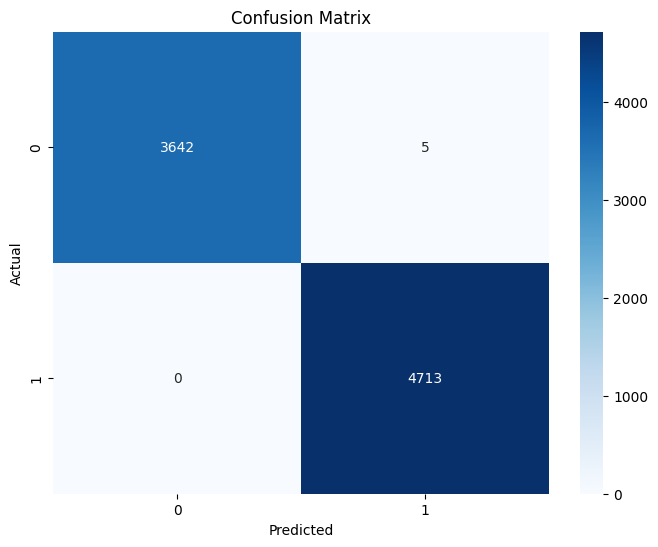

In [196]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [197]:
# Registrar las métricas y artefactos en MLflow
"""
with mlflow.start_run(run_name="Best Model Test Evaluation"):
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc_roc", auc_roc)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_text(class_report, "classification_report.txt")
"""

'\nwith mlflow.start_run(run_name="Best Model Test Evaluation"):\n    mlflow.log_metric("accuracy", accuracy)\n    mlflow.log_metric("precision", precision)\n    mlflow.log_metric("recall", recall)\n    mlflow.log_metric("f1_score", f1)\n    mlflow.log_metric("auc_roc", auc_roc)\n    mlflow.log_artifact("confusion_matrix.png")\n    mlflow.log_text(class_report, "classification_report.txt")\n'

# PENDIENTE: Configurar correctamente MLflow

# PENDIENTE: Convertir los notebooks a scripts de Python

### Interpretación del Modelo y Análisis de Importancia de Características

In [198]:
# Realizar análisis de importancia de características
# ...

# Visualizar la importancia de las características
# ...

### Serialización y Guardado del Modelo

In [199]:
# Serializar y guardar el mejor modelo
# ...

### Monitoreo y Seguimiento del Rendimiento del Modelo

In [200]:
# Configurar mecanismos de logging y monitoreo
# ...

# Definir métricas y umbrales para detección de anomalías
# ...

### Mantenimiento y Reentrenamiento del Modelo

In [201]:
# Establecer un proceso para actualizar el modelo con nuevos datos
# ...

# Definir la frecuencia y criterios para el reentrenamiento del modelo
# ...